In [29]:
import scipy.io as scio 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from sklearn.cluster import KMeans
import spectral as sp
import numpy as np
import glob
import os 
from sklearn.cluster import KMeans
import skimage as ski 
import skfuzzy as skf
from configparser import ConfigParser
from scipy import ndimage 

In [40]:
pavia = {'rgb': scio.loadmat('PaviaRGB.mat')['PaviaRGB'],
         'color_map' : scio.loadmat('PaviaColorMap.mat')['PaviaColorMap'],
         'ground_truth' : scio.loadmat('PaviaGrTruth.mat')['PaviaGrTruth'],
         'ground_truth_mask' : scio.loadmat('PaviaGrTruthMask.mat')['PaviaGrTruthMask'],
         'hyperimage' : scio.loadmat('PaviaHyperIm.mat')['PaviaHyperIm'],
         'wavelengths' : scio.loadmat('PaviaWavelengths.mat')['PaviaWavelengths'],
        }
sanbar = {'rgb': scio.loadmat('SanBarRGB.mat')['SanBarRGB'],
          'wavelengths': scio.loadmat('SanBarWavelengths.mat')['WaveLengths'],
          'hyperimage': scio.loadmat('SanBarHyperIm.mat')['SanBarIm88x400'],
         }

config = ConfigParser()
config.read('appConfig.ini')
FCM = 'FCM'
KMEANS = 'KMeans'
HYPER = 'Hyper'
N_CLUSTERS = 'n_clusters'
N_COMPONENTS = 'n_components'
FUZZ_DEGREE = 'fuzz_degree'
ERROR = 'error'
MAX_ITER = 'max_iter'
CONNECTED_COMPONENTS = 'ConnectedComponents'
SEED = 'seed'
BLUR_RADIUS = 'blur_radius'
THRESHOLD = 'threshold'



def k_means_clustering(inp=pavia['rgb'], n_clusters=2):
    if inp is None:
        print("Empty Input. Exiting")
    k_means = KMeans(n_clusters=n_clusters)
    shape = inp.shape
    k_means.fit(inp.flatten().reshape(shape[0]*shape[1],shape[2]))
    inp_clustered = k_means.labels_.astype(float)
    return inp_clustered.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])

def fuzzy_c_means(n_clusters=2,fuzz_degree=2,error=0.005,max_iter=1000,inp_image=pavia['rgb']):
    shape = inp_image.shape
    centers, u, u0, d, jm, n_iters, fpc = skf.cluster.cmeans(
        inp.flatten().reshape(shape[0]*shape[1],shape[2]).T,
        c=n_clusters,
        m=fuzz_degree,
        error=error,
        maxiter=max_iter,
        init=None,
        seed=config.getint(FCM, SEED)
    )
    clust = np.argmax(u, axis=0).astype(float)
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])

In [41]:
def MyClust(image=pavia['rgb'],params={'Algorithm': 'KMeans',
                                       'ImType': 'RGB',
                                       'NumClusts': 3}):
    inp_image = image
    shape = inp_image.shape
    CCIm = None
    out_labels = None 
    if params['ImType'].upper() == 'HYPER':
        n_components = config.getint(HYPER, N_COMPONENTS)
        pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
        inp_image = pca.transform(inp_image).reshape(shape[0],shape[1],n_components)
    # TODO Add logic for determining number of clusters 
    
    if params['Algorithm'].upper() == 'KMEANS':
        out_labels = k_means_clustering(inp=inp_image, n_clusters=config.getint(KMEANS, N_CLUSTERS))   
    elif params['Algorithm'].upper() == 'FCM':
        out_labels = fuzzy_c_means(inp_image=inp_image,
                                   n_clusters=config.getint(FCM, N_CLUSTERS),
                                   fuzz_degree=config.getint(FCM, FUZZ_DEGREE),
                                   error=config.getfloat(FCM, ERROR),
                                   max_iter=config.getint(FCM, MAX_ITER))
    elif params['Algorithm'].upper() == 'SOM':    
        # TODO Add Implementation 
        pass 
    elif params['Algorithm'].upper() == 'SPECTRAL':
        # TODO Add Implementation 
        pass 
    else:
        print('Invalid Algorithm Entered')
        return None, None 
    
    if params['ImType'].upper() == 'RGB':
        im_gf = ndimage.gaussian_filter(inp_image, config.getfloat(CONNECTED_COMPONENTS, BLUR_RADIUS))
        CCIm, nr_objects = ndimage.label(im_gf > config.getfloat(CONNECTED_COMPONENTS, THRESHOLD)) 
    #TODO Figure out how to attach labels to input image 
    return out_labels, CCIm
    

In [46]:
out_labels, CCIm = MyClust()

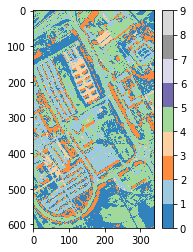

In [47]:
def label_show(im):
    cmap = cm.get_cmap('tab20c', 9)    # 11 discrete colors
    plt.figure(2020)
    plt.subplot(1,2,1)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=9)
    plt.colorbar(ticks=np.linspace(0,9,10))
    plt.show()
    
label_show(out_labels)

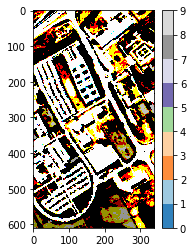

In [49]:
label_show(CCIm.astype(float))